# Chest-xray-pneumonia Classification
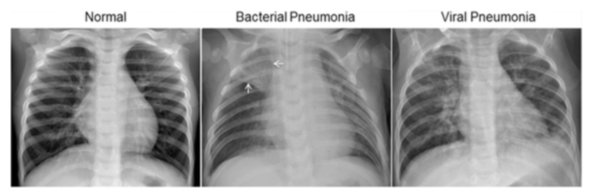
## Dataset
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
# Modeling
### we used MobileNet 

# import Libraries

In [120]:
import os
import cv2
import glob
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.utils import resample
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization,MaxPooling2D,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, precision_score, recall_score
from keras.layers import Conv2D,Dense,Dropout,GlobalAveragePooling2D,MaxPool2D
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import logging
# Set TensorFlow log level to only display errors
tf.get_logger().setLevel(logging.ERROR)

# Load dataset
Load all paths in list

In [121]:
data_dir='/kaggle/input/chest-xray-pneumonia/chest_xray'
paths=glob.glob(data_dir+'/*/*/*.jpeg')
print(f'found {len(paths)} images in the dataset')
paths[:5]

found 5856 images in the dataset


['/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg']

now load them in dataframe and extract label from path

In [122]:
df=pd.DataFrame(paths,columns=['path'])
df['label']=df['path'].apply(lambda x:x.split('/')[6].strip())
df.head()

,path,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA


# EDA

In [123]:
counts=df['label'].value_counts()
counts

label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64

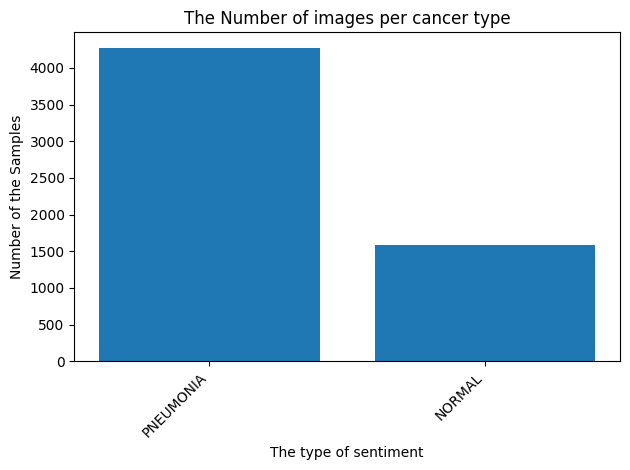

In [124]:
plt.bar(['PNEUMONIA','NORMAL'], counts, width=0.8)
plt.xlabel('The type of sentiment')
plt.ylabel('Number of the Samples')
plt.title("The Number of images per cancer type")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

## Plot some images

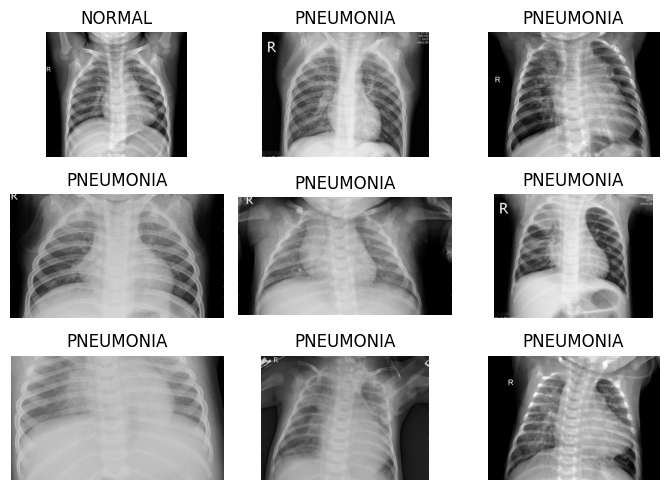

In [125]:
num_images=9
# Randomly sample num_images from the DataFrame
sampled_df = df.sample(n=num_images).reset_index(drop=True)

plt.figure(figsize=(7, 5))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)

    # Read the image
    img_path = sampled_df.iloc[i]['path']
    img = plt.imread(img_path)

    plt.imshow(img,cmap='gray')
    plt.title(sampled_df.iloc[i]['label'])
    plt.axis('off')

plt.tight_layout()
plt.show()

note that image snot have the same size 

# Handle Imbalancing

### We see the data is imbalnced we used Downsampling :
- we Reduce the number of instances in the majority class (PNEUMONIA) to match the number of instances in the minority class (NORMAL).

In [126]:
df_majority = df[df.label == 'PNEUMONIA']
df_minority = df[df.label == 'NORMAL']

In [127]:
# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,  
                                   n_samples=len(df_minority), 
                                   random_state=42)  

# Combine minority class with downsampled majority class
df = pd.concat([df_minority, df_majority_downsampled])

In [128]:
counts=df['label'].value_counts()
counts

label
NORMAL       1583
PNEUMONIA    1583
Name: count, dtype: int64

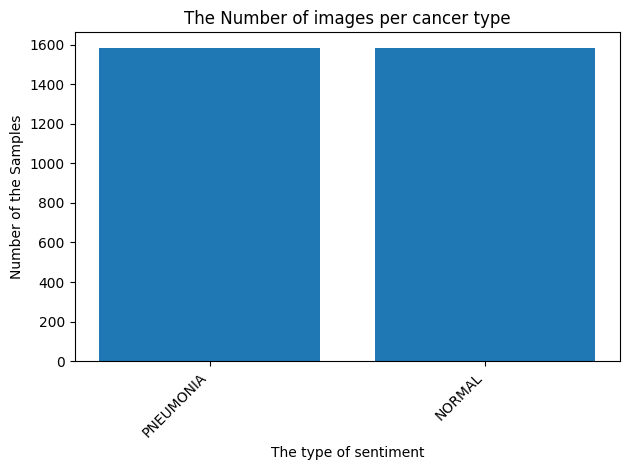

In [129]:
plt.bar(['PNEUMONIA','NORMAL'], counts, width=0.8)
plt.xlabel('The type of sentiment')
plt.ylabel('Number of the Samples')
plt.title("The Number of images per cancer type")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

### Convert labels to binary values

In [130]:
df

,path,label
8,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
9,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
10,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
11,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
12,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
...,...,...
4473,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3774,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3781,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3370,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA


In [131]:
df['label'] = df['label'].apply(lambda x: '1' if x == 'PNEUMONIA' else '0')
df.head()

,path,label
8,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
9,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
10,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
11,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
12,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0


In [132]:
df['label'].value_counts()

label
0    1583
1    1583
Name: count, dtype: int64

### shuffle tha data

In [133]:
df=df.sample(frac=1.0, random_state=42)
df.head(5)

,path,label
4837,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
5603,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
568,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
1101,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
117,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1


# Split data

In [134]:
# Splitting data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, valid_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print("Training set shapes:", train_df.shape)
print("Validation set shapes:", valid_df.shape)
print("Testing set shapes:", test_df.shape)

Training set shapes: (2532, 2)
Validation set shapes: (317, 2)
Testing set shapes: (317, 2)


In [135]:
train_df['label'].value_counts()

label
1    1277
0    1255
Name: count, dtype: int64

# Data Generattors

In [136]:
train_datagen = ImageDataGenerator(    
    rescale=1.0/255,        
#     shear_range=0.2,
#     rotation_range=.1,
#     zoom_range=0.2,       
#     horizontal_flip=True ,
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [137]:
# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path', 
    y_col='label',   
    target_size=(150, 150), 
    batch_size=32,
    class_mode='binary', 
    color_mode='rgb',
    shuffle=True
)

# Validation data generator
valid_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path', 
    y_col='label',
    target_size=(150, 150), 
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False  
)

# Testing data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path', 
    y_col='label',  
    target_size=(150, 150),  
    color_mode='rgb',
    batch_size=64,  
    class_mode='binary',
    shuffle=False  
)

Found 2532 validated image filenames belonging to 2 classes.
Found 317 validated image filenames belonging to 2 classes.
Found 317 validated image filenames belonging to 2 classes.


get class names

In [138]:
classes=['NORMAL','PNEUMONIA']
classes

['NORMAL', 'PNEUMONIA']

plot some images after resizing and Augementation

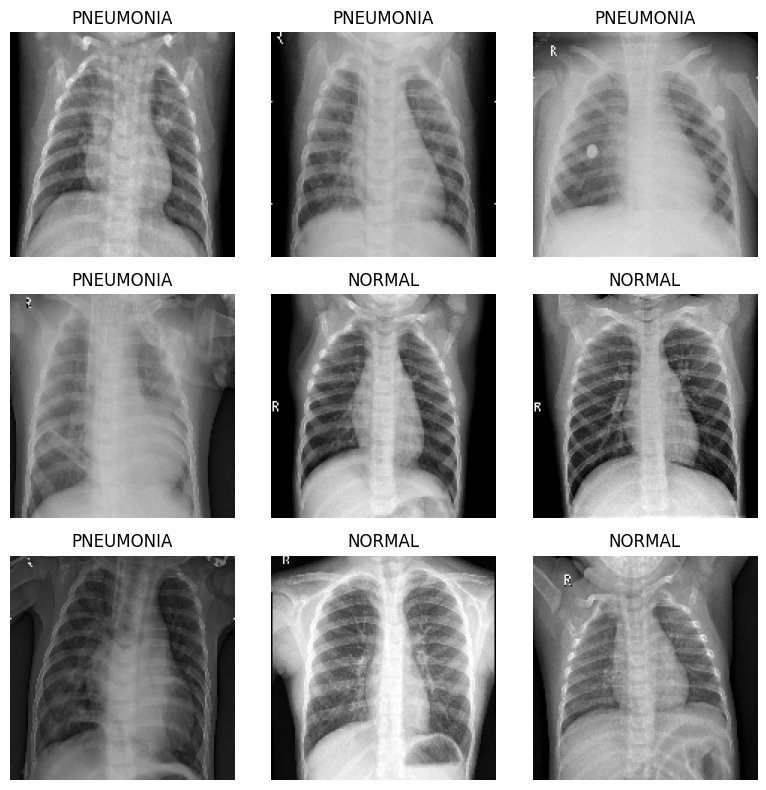

In [139]:
batch_size = 9
# Generate a batch of images and labels
images, labels = next(train_generator)
# Plot the images with their labels
plt.figure(figsize=(8, 8))
for i in range(min(len(images), 9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i],cmap='gray')
    plt.title(f"{classes[int(labels[i])]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# MobileNet

In [140]:
train_generator.image_shape

(150, 150, 3)

In [142]:
from keras.applications import MobileNetV2
mobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze pretrained layers
for layer in mobileNetV2.layers:
    layer.trainable = False


model

In [144]:
mobileNet=keras.models.Sequential([
    mobileNetV2,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'), 
    Dropout(0.5),  
    Dense(1, activation='sigmoid') 
])

mobileNet.add(Dense(1,activation='sigmoid'))
mobileNet.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [145]:
mobileNet.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [147]:
weight_path = "cnn_weights.best.weights.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

early = EarlyStopping(monitor="val_accuracy", 
                      mode="max", 
                      patience=4)

callbacks_list = [checkpoint, early]

In [148]:
mobileNet_history=mobileNet.fit(train_generator,epochs=5,validation_data=valid_generator,callbacks=callbacks_list)

Epoch 1/5
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9281 - loss: 0.4896
Epoch 1: val_accuracy improved from -inf to 0.94953, saving model to cnn_weights.best.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 32s 375ms/step - accuracy: 0.9281 - loss: 0.4894 - val_accuracy: 0.9495 - val_loss: 0.4562
Epoch 2/5
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9392 - loss: 0.4662
Epoch 2: val_accuracy improved from 0.94953 to 0.95584, saving model to cnn_weights.best.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 31s 364ms/step - accuracy: 0.9390 - loss: 0.4661 - val_accuracy: 0.9558 - val_loss: 0.4384
Epoch 3/5
77/80 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - accuracy: 0.9465 - loss: 0.4523
Epoch 3: val_accuracy did not improve from 0.95584
80/80 ━━━━━━━━━━━━━━━━━━━━ 33s 389ms/step - accuracy: 0.9460 - loss: 0.4525 - val_accuracy: 0.9527 - val_loss: 0.4266
Epoch 4/5
77/80 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step - accuracy: 0.9419 - loss: 0.4402
Epoch 4: val_accuracy did not improve from 0.95584
80/80 ━

In [150]:
# load the best weights
mobileNet.load_weights(weight_path)

# Evaluate model

In [151]:
# Evaluate the model on the test data
evaluation_result = mobileNet.evaluate(test_generator)

# The result
print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9421 - loss: 0.4479 
Test Loss: 0.45253437757492065
Test Accuracy: 0.9305993914604187


## MobileNet Confusion Matrix

In [152]:
y_pred = mobileNet.predict(test_generator)

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step  


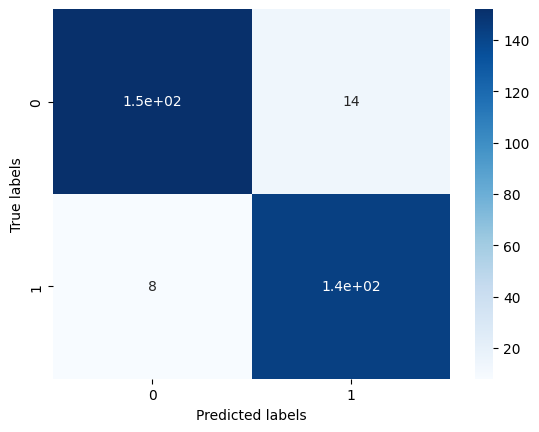

In [153]:
y_pred_binary = np.squeeze(np.round(y_pred))
# confusion matrix
confusion_Matrix = confusion_matrix(test_generator.classes, y_pred_binary)
confusion_Matrix

sns.heatmap(confusion_Matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Training and Validation performance

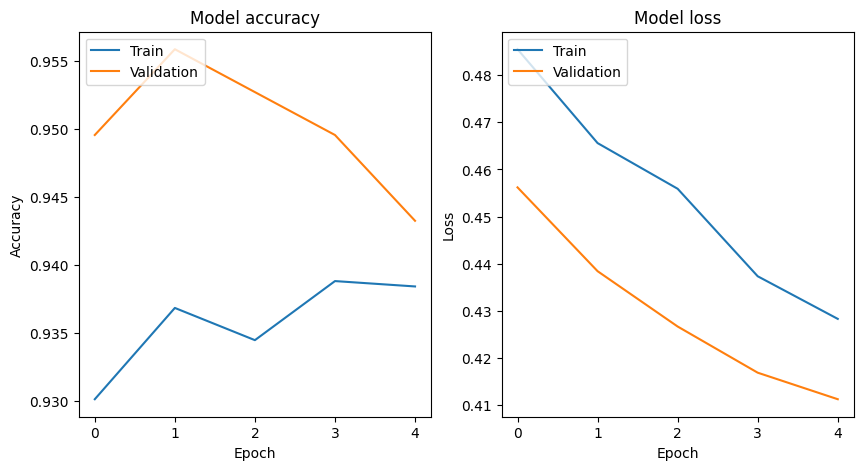

In [154]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Plot the training and validation accuracy
ax1.plot(mobileNet_history.history['accuracy'])
ax1.plot(mobileNet_history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot the training and validation loss
ax2.plot(mobileNet_history.history['loss'])
ax2.plot(mobileNet_history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

# Display the plots
plt.show()

## Classification Report

In [155]:
mobilenet_pred_binary = np.squeeze(np.round(y_pred))
print(classification_report(test_generator.classes, mobilenet_pred_binary))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       166
           1       0.91      0.95      0.93       151

    accuracy                           0.93       317
   macro avg       0.93      0.93      0.93       317
weighted avg       0.93      0.93      0.93       317



## MobileNet AUC curve for binary classification

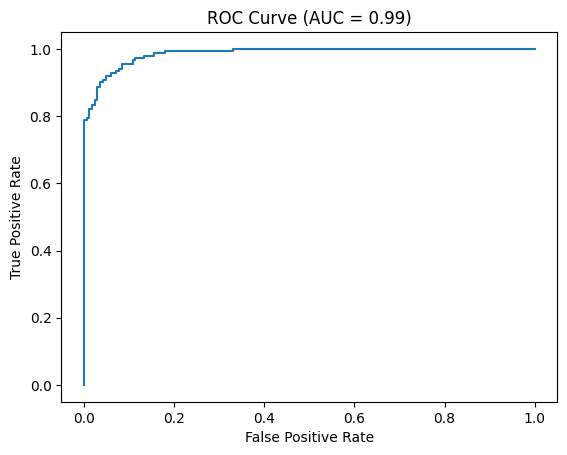

In [156]:
from sklearn.metrics import roc_curve, roc_auc_score


# Compute the FPR, TPR, and thresholds for various classification thresholds
fpr, tpr, thresholds = roc_curve(test_generator.classes, y_pred)

# Compute the AUC score
auc_score = roc_auc_score(test_generator.classes, y_pred)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {auc_score:.2f})')
plt.show()

# Test the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


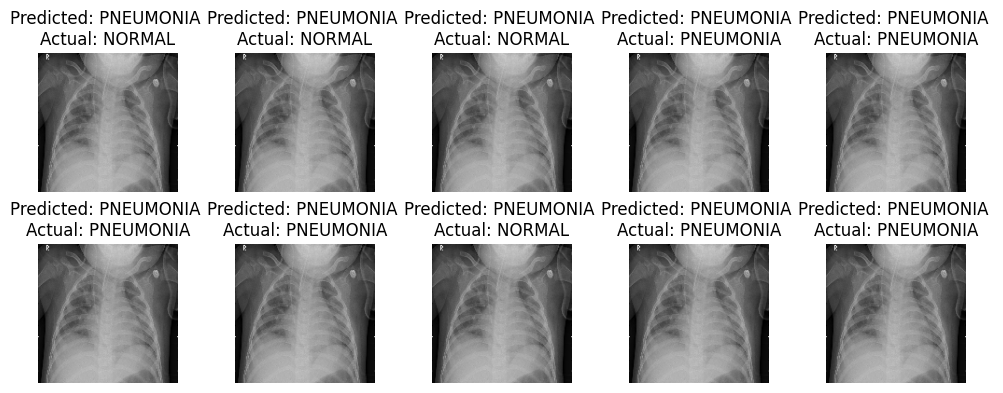

In [172]:
x_test,y_test=next(test_generator)
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()

for i in range(10):
    predicted = mobileNet.predict(np.array([x_test[testimgnum]]))
    predictedClass = int(predicted >= 0.5)
    actual = int(y_test[i])

    axs[i].imshow(x_test[testimgnum], cmap='gray')
    axs[i].set_title(f'Predicted: {classes[predictedClass]} \nActual: {classes[actual]}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()
